# Hello PyGraphistry[ai] - HackerNews visual semantic search with UMAP & BERT.

`PyGraphistry[ai]` can quickly create visual graph search interfaces for structured text. It automates much of the work in cleaning, connecting, encoding, searching, and visualing graph data. The result is increasing the *time to graph* and overall results in as little as one line of code.

This notebook shows how to turn 3,000 HackerNews articles into an interactive visual graph with full semantic search. The core flow is a short number of lines and trains in 2 minutes on a CPU and 100-200x faster on GPU. The notebooks carefully demonstrate how to create a fast automatic feature engineering pipeline, which exposes matrices and targets, a Scikits like API, full semantic search over the data which returns dataframes or subgraphs from the query, and `GNN` models and pipelines.

Outline:

* load the data into a graphistry instance, `g = graphistry.nodes(dataframe)`
* since we do not have explicit edges, we will create a similarity graph using UMAP, `g.umap(..)` 
    which will call the `g.featurize(...)` api to create features, then UMAP them, adding an implicit edge dataframe which you can access with `g._edges` (with `g._nodes` the original dataframe) 
* Once the models are built we can search the data and display subgraphs from the search query itself
    using `g.search(query)` and `g.search_graph(query).plot()`
* Transforming on new data using `g.transform(..)`, useful for online or API driven endpoints after a data model has been set
* lastly, create a DGL GNN data model `g.build_gnn(...)` which may be used for downstream `GNN` modeling

Searching over data is useful to refine and find sugraphs over the global corpus of documents/events/data. Search can be operationalized over logs data (see morpheus demo), eCommerce (see clickstream and user-item-recommendation demo), stock and coin data (see crypto-slim demo), OSINT data, etc.

`GNN`s built over these feature encodings are useful for downstream modeling like link prediction, node classification, motif mining and other popular graph AI pipelines. 

In [ ]:
#! pip install --upgrade graphistry[ai]   # get the latest graphistry AI 

In [1]:
import os
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import graphistry

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth', 200)

In [2]:
alpha = 1/137
np.random.seed(int(alpha**-1))  

In [ ]:
# add your hub credentials here
graphistry.register(api=3, protocol="https", server="hub.graphistry.com", username = os.environ['USERNAME'], password=os.environ['GRAPHISTRY_PASSWORD'])

In [3]:
# get the data top 3000 posts on Hacker News
df = pd.read_csv('https://storage.googleapis.com/cohere-assets/blog/text-clustering/data/askhn3k_df.csv', index_col=0)

In [4]:
good_cols = ['title', 'text']

In [5]:
df.columns

Index(['title', 'url', 'text', 'dead', 'by', 'score', 'time', 'timestamp',
       'type', 'id', 'parent', 'descendants', 'ranking', 'deleted'],
      dtype='object')

In [6]:
df.head()  # see the dataset

,title,url,text,dead,by,score,time,timestamp,type,id,parent,descendants,ranking,deleted
0,"I'm a software engineer going blind, how should I prepare?",<NA>,"I&#x27;m a 24 y&#x2F;o full stack engineer (I know some of you are rolling your eyes right now, just highlighting that I have experience on frontend apps as well as backend architecture). I&#x27;v...",<NA>,zachrip,3270,1587332026,2020-04-19 21:33:46+00:00,story,22918980,<NA>,473.0,<NA>,<NA>
1,Am I the longest-serving programmer – 57 years and counting?,<NA>,"In May of 1963, I started my first full-time job as a computer programmer for Mitchell Engineering Company, a supplier of steel buildings. At Mitchell, I developed programs in Fortran II on an IB...",<NA>,genedangelo,2634,1590890024,2020-05-31 01:53:44+00:00,story,23366546,<NA>,531.0,<NA>,<NA>
2,Is S3 down?,<NA>,I&#x27;m getting<p>{\n &quot;errorCode&quot; : &quot;InternalError&quot;\n}<p>When I attempt to use the AWS Console to view s3,<NA>,iamdeedubs,2589,1488303958,2017-02-28 17:45:58+00:00,story,13755673,<NA>,1055.0,<NA>,<NA>
3,What tech job would let me get away with the least real work possible?,<NA>,"Hey HN,<p>I&#x27;ll probably get a lot of flak for this. Sorry.<p>I&#x27;m an average developer looking for ways to work as little as humanely possible.<p>The pandemic made me realize that I do no...",<NA>,lmueongoqx,2022,1617784863,2021-04-07 08:41:03+00:00,story,26721951,<NA>,1091.0,<NA>,<NA>
4,What books changed the way you think about almost everything?,<NA>,I was reflecting today about how often I think about Freakonomics. I don&#x27;t study it religiously. I read it one time more than 10 years ago. I can only remember maybe a single specific anecdot...,<NA>,anderspitman,2009,1549387905,2019-02-05 17:31:45+00:00,story,19087418,<NA>,1165.0,<NA>,<NA>


In [7]:
df[good_cols].head()

,title,text
0,"I'm a software engineer going blind, how should I prepare?","I&#x27;m a 24 y&#x2F;o full stack engineer (I know some of you are rolling your eyes right now, just highlighting that I have experience on frontend apps as well as backend architecture). I&#x27;v..."
1,Am I the longest-serving programmer – 57 years and counting?,"In May of 1963, I started my first full-time job as a computer programmer for Mitchell Engineering Company, a supplier of steel buildings. At Mitchell, I developed programs in Fortran II on an IB..."
2,Is S3 down?,I&#x27;m getting<p>{\n &quot;errorCode&quot; : &quot;InternalError&quot;\n}<p>When I attempt to use the AWS Console to view s3
3,What tech job would let me get away with the least real work possible?,"Hey HN,<p>I&#x27;ll probably get a lot of flak for this. Sorry.<p>I&#x27;m an average developer looking for ways to work as little as humanely possible.<p>The pandemic made me realize that I do no..."
4,What books changed the way you think about almost everything?,I was reflecting today about how often I think about Freakonomics. I don&#x27;t study it religiously. I read it one time more than 10 years ago. I can only remember maybe a single specific anecdot...


# Featurize and Encode the Data

In [8]:
from time import time
t0 = time()
################################################################
## Two Lines of codes cuts through 80% of the datasciencing 

df = df.sample(3000) # set smaller if you want to test a minibatch 

################################################################
# create the graphistry instance
g = graphistry.nodes(df)

# set to False if you want to reload last trained instance
process = True

print('-'*80)
if process:
    # Umap will create a similarity graph from the features which we can view as a graph
    g2 = g.umap(X=['title'], # the features to encode (can add/remove 'text', etc)
                y=['score'], # for demonstrative purposes, we include a target -- though this one is not really conditioned on textual features in a straightforward way
                model_name='msmarco-distilbert-base-v2', #'paraphrase-MiniLM-L6-v2', etc, from sbert/Huggingface, the text encoding model
                min_words = 0, # when 0 forces all X=[..] as textually encoded, higher values would ascertain if a column is textual or not depending on average number of words per column
                use_ngrams=False, # set to True if you want ngram features instead (does not make great plots but useful for other situations)
                use_scaler_target='standard', # for regressive targets
                use_scaler=None, # there are many more settings see `g.featurize?` and `g.umap?` for further options
               )
    g2.save_search_instance('hn.search')
    print(f'Encoding {df.shape[0]} records using {str(g2._node_encoder.text_model)[:19]} took {(time()-t0)/60:.2f} minutes')
else:
    # or load the search instance
    g2 = g.load_search_instance('hn.search')
    print(f'Loaded saved instance')
    
################################################################


--------------------------------------------------------------------------------


! Failed umap speedup attempt. Continuing without memoization speedups.

Encoding 3000 records using SentenceTransformer took 0.11 minutes


In [ ]:
# see all the data
g2.plot()

In [9]:
# get the encoded features, and use in downstream models (clf.fit(x, y), etc)
x=g2._get_feature('nodes')
# same as 
x = g2._node_features
# same as
x = g2.get_matrix()
x

,title_0,title_1,title_2,title_3,title_4,title_5,title_6,title_7,title_8,title_9,...,title_374,title_375,title_376,title_377,title_378,title_379,title_380,title_381,title_382,title_383
86,0.116835,0.047611,0.123571,-0.003869,-0.287165,-0.630044,0.675428,-0.535482,0.193938,0.071750,...,0.456389,-0.449447,0.155794,0.048731,-0.133477,0.220336,0.096380,-0.013204,0.173043,0.282234
629,-0.110388,-0.443630,0.312864,0.018900,0.218698,-0.107563,-0.309971,0.087803,-0.147444,-0.122583,...,0.131936,-0.171861,-0.209886,0.265294,-0.469090,0.089367,0.258376,-0.218613,-0.054000,0.089419
1775,0.111770,0.186021,0.011021,0.381925,0.149911,0.076566,0.046410,0.434330,0.477412,-0.044378,...,0.225702,-0.767549,0.116685,-0.203653,-0.123361,-0.124989,0.573242,-0.208231,-0.149974,0.216172
1130,-0.254852,-0.418337,0.385770,0.213150,0.534382,0.262631,-0.162246,-0.324757,-0.076974,0.112634,...,-0.021624,-0.225333,-0.186645,-0.344636,-0.355452,0.183701,-0.113490,-0.906534,-0.062090,0.174838
74,-1.072934,0.174145,0.373213,0.472789,0.219836,-0.203455,-0.417215,-0.433594,-0.126521,-0.212785,...,-0.141908,-0.591009,0.072475,0.434016,-0.428241,0.159616,-0.030208,-0.365394,-1.405699,0.122592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2846,-0.102582,-0.236058,-0.565881,-0.170961,0.054142,0.108368,0.006405,-0.060202,0.219438,-0.132710,...,0.220599,0.096765,0.045080,-0.166784,0.169851,-0.115570,0.049157,-0.567069,0.412393,0.405345
1285,-0.695153,-0.391451,-0.008690,0.029619,-0.169425,-0.147258,0.120400,0.118067,-0.002243,-0.547840,...,0.217005,-0.200350,-0.162029,0.354674,0.413775,-0.128707,0.251495,-1.372315,-1.203632,0.191290
637,-0.402637,-0.216433,-0.604958,-0.729204,-0.191468,0.140602,-0.151620,-0.120674,-0.133293,0.693629,...,0.635778,-0.036623,-0.061704,-0.935613,-0.046723,0.413536,-0.830954,0.262067,-0.198192,0.168310
678,-0.216255,0.183433,-0.247350,-0.084486,-0.455666,-0.024263,0.178698,-0.272283,0.380426,0.009210,...,-0.153914,0.103745,0.401287,-0.582803,0.263595,0.575202,-0.194838,0.264890,-0.047696,-0.608032


In [10]:
# likewise with the (scaled) targets
y = g2._get_target('nodes')
# same as 
y = g2._node_target
# same as
y = g2.get_matrix(target=True)
y

,score
86,738
629,337
1775,166
1130,238
74,780
...,...
2846,107
1285,216
637,336
678,327


In [11]:
# visualize the results where we prune edges using the `filter_weighted_edges` method
# this keeps all weights that are (more similar) 0.5 and above. The initial layout is the same (given by umap in 2d)
g25 = g2.filter_weighted_edges(0.5)
g25.plot(render=True)

# Let's query the graph

In [12]:
# direct keyword search when fuzzy=False and a set of columns are given, does not require featurization
g.search('love', fuzzy=False, cols=['title'])[0][['title']]

,title
1182,Have you found something you love to do? If yes how?
2854,Hackers falling in love
1412,What landing page do you love?
1647,Is it normal to fall out of love with coding?
2770,What do you love/hate about terminals? Would you change them?


In [13]:
g2.search('love')[0][['title']]

,title
1182,Have you found something you love to do? If yes how?
1412,What landing page do you love?
2509,After almost 30 years the romance is over - What now?
969,How to cope with the death of a dear person?
390,Am I just a wantrepreneur?
1474,Share a gem. Teach me and you.
741,I'm So Lonely
2532,How did you find your passion?
66,The “I want to do everything but end up doing nothing” dilemma
1734,"Show me the sexy, sexy home page of your favorite free CLI project"


In [14]:
# Query semantically instead of strict keyword matching

sample_queries = ['Is true love possible?', 
                  'How to create deep learning models?', 
                  'Best tech careers',
                  'How do I make more money?', 
                  'Advances in particle physics', 
                  'Best apps and gadgets', 
                  'Graph Neural Networks', 
                  'recommend impactful books', 
                  'lamenting about life']

for query in sample_queries:
    print('*'*33)
    print(query)
    print('*'*30)
    # use the featurized instance g2 for semantic search
    results_df, encoded_query_vector = g2.search(query)
    print(results_df['title'])
    print('-'*60)

*********************************
Is true love possible?
******************************
1182                 Have you found something you love to do? If yes how?
390                                            Am I just a wantrepreneur?
2509                After almost 30 years the romance is over - What now?
66         The “I want to do everything but end up doing nothing” dilemma
1647                        Is it normal to fall out of love with coding?
1778    I feel my career is at a dead end. Any advice on what could I do?
2923                                     Maybe I'm just not smart enough?
1684                                                    What should I do?
320                                                      Is it me or ...?
1145            How does one overcome the need for instant gratification?
Name: title, dtype: object
------------------------------------------------------------
*********************************
How to create deep learning models?
**************

# Search to Graph

We may also query and create a graph of results. This returns the nodes found during `g.search` and then pulls in any edges of those nodes in both the `src` AND `dst` or, with `broader=True`, with nodes in `src` OR `dst` -- the latter can be useful in user-relationship-item/user/behavioral datasets and recommendation strategies where NLP search can help recall/create ontologically similar mini-batches to broaden scope. 

In [17]:
gr = g2.search_graph('How to create deep learning models', thresh=15, top_n=50, scale=0.25, broader=False) 
gr.plot()

In [18]:
g2.search_graph('Graph Neural Networks', thresh=50, top_n=50, scale=0.1, broader=False).plot()

In [19]:
g2.search_graph('fraud detection algorithms', thresh=50, top_n=50, scale=0.1, broader=False).plot()  # works better if you encode 'text' column as well

# To Demonstrate transforming on new or unseen data (imagine a train test split or new mini batch)

In [15]:
sdf = df.sample(10)
x, y = g2.transform(sdf, sdf, return_graph=False)  # or edges if given or already produced through umap-ing the ny_nodes=
                                                                #and if neither, set `embedding=True` for random embedding of size `n_topics`
x

,title_0,title_1,title_2,title_3,title_4,title_5,title_6,title_7,title_8,title_9,...,title_374,title_375,title_376,title_377,title_378,title_379,title_380,title_381,title_382,title_383
673,-0.521209,0.111729,0.076023,-0.041530,0.002010,-0.284490,0.320005,-0.086221,-0.090570,-0.203005,...,-0.016702,0.201610,0.091499,-0.405620,-0.390063,0.151630,0.042480,-0.673492,-0.045278,0.289963
1147,-0.272912,-0.706757,0.285584,-0.066503,0.582760,0.060587,0.206524,-0.272755,0.324543,-0.271787,...,0.122684,-0.457361,0.367833,-0.131638,-0.647704,0.201357,0.596976,-0.499390,0.091331,-0.065770
1419,-0.704890,-0.400973,-0.087487,-0.120381,0.497610,-0.205861,-1.142517,0.197171,-0.672273,0.731331,...,-0.017972,-0.324373,-0.172686,-0.504152,0.263801,0.654255,0.129250,-0.449582,-0.307157,0.124731
2341,0.247818,-0.345609,0.382842,-0.303950,0.199858,0.400998,-0.076884,-0.169786,-0.335778,0.069415,...,0.358036,0.457022,-0.303442,-0.057899,-0.690475,0.031366,-0.114160,-0.343221,0.385754,0.139402
109,-0.686867,0.095947,-0.098436,-0.405435,-0.535073,0.069658,-0.678227,0.165947,-0.511108,-0.033262,...,0.389929,-0.054180,-0.053430,-0.556131,-0.188888,-0.061940,-0.432450,-0.257399,-0.216869,0.539751
1903,-0.119729,0.309991,0.018289,0.445053,0.584751,-0.247848,-0.552697,-0.019735,0.036155,0.077356,...,0.042397,0.544143,-0.042308,-0.147386,-0.653150,0.393202,0.414596,-0.065031,0.525993,-0.260655
2145,-0.260399,-0.372146,-0.273868,-0.250745,0.081625,-0.155578,-0.342647,-0.224763,0.104961,0.076875,...,0.285180,-0.348447,0.049559,-0.045127,0.028311,0.448438,0.322343,-0.261815,0.178996,0.109257
1331,0.024533,-0.278011,0.080756,-0.010837,0.190887,-0.296632,-0.320455,0.547781,-0.325564,-0.193407,...,0.706718,-0.166657,-0.555037,-0.113920,-0.517266,-0.209852,-0.727203,-0.005706,0.338997,0.128958
1527,0.256320,0.249440,0.122028,0.053941,-0.163918,-0.215514,0.196959,-0.210308,-0.462466,-0.104889,...,0.153879,-0.528928,0.396670,0.315690,-0.399469,-0.230737,0.354914,-0.425400,-1.237193,0.120400
152,-0.060516,-0.551372,0.549204,0.153618,0.551138,0.089013,0.175666,-0.288338,-0.219612,0.033492,...,0.016371,-0.040019,-0.259015,-0.292096,-0.134451,0.030437,-0.165715,-0.544421,-0.017898,0.302884


Likewise, we can `transform_umap` to get the embedding coordinates as well

In [20]:
emb, x, y = g2.transform_umap(df.sample(10), df.sample(10), return_graph=False)
emb.head()

,x,y
2145,5.735580,0.156245
1640,-2.329779,-2.715624
228,-0.409523,-1.209444
1915,-1.273383,-1.469138
1044,1.404568,-2.191309


# Build a GNN model 

In [21]:
# this inherets all the arguments from the g.featurize api for both nodes and edges, see g.build_gnn? for details
g3 = g25.build_gnn(y_nodes='score')  # we use the filtered edges graphistry instance as it has higher fidelity similarity scores on edges
                        # ie, less edges

In [22]:
g3.get_matrix(kind='edges').head()

,0,1,2,3,4,5,6,7,8,9,...,2991,2992,2993,2994,2995,2996,2997,2998,2999,_weight
9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.502490
11,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.515844
13,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.515843
14,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.927416
15,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000


In [24]:
# Since edges are featurized, we can transform on "unseen/batch" ones
edge_data = g3._edges.sample(10)

# y_edges will be None since we don't have a label for the implicit edges. One could supply it via enrichment (like clustering, annotation etc)
x_edges, _ = g3.transform(edge_data, None, kind='edges', return_graph=False)
x_edges.head()

,0,1,2,3,4,5,6,7,8,9,...,2991,2992,2993,2994,2995,2996,2997,2998,2999,_weight
22336,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.927078
42974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.543202
41456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.945208
28712,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.747347
36043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.717154


In [25]:
# once built, we can get the DGL graph itself
G = g3._dgl_graph
G

Graph(num_nodes=3000, num_edges=18430,
      ndata_schemes={'feature': Scheme(shape=(384,), dtype=torch.float32), 'target': Scheme(shape=(1,), dtype=torch.int64), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={'feature': Scheme(shape=(3001,), dtype=torch.float64), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool)})

In [26]:
# the features, targets, and masks
G.ndata

{'feature': tensor([[ 0.1168,  0.0476,  0.1236,  ..., -0.0132,  0.1730,  0.2822],
        [-0.1104, -0.4436,  0.3129,  ..., -0.2186, -0.0540,  0.0894],
        [ 0.1118,  0.1860,  0.0110,  ..., -0.2082, -0.1500,  0.2162],
        ...,
        [-0.4026, -0.2164, -0.6050,  ...,  0.2621, -0.1982,  0.1683],
        [-0.2163,  0.1834, -0.2474,  ...,  0.2649, -0.0477, -0.6080],
        [-0.3673, -0.2972, -0.4606,  ...,  0.3154,  0.3731,  0.2686]]), 'target': tensor([[738],
        [337],
        [166],
        ...,
        [336],
        [327],
        [186]]), 'train_mask': tensor([False,  True,  True,  ...,  True,  True,  True]), 'test_mask': tensor([ True, False, False,  ..., False, False, False])}

In [27]:
# `build_gnn()` will turn edges gotten from umap into bonafide feature matrices, 
# and make features out of explicit edges with `build_gnn(X_edges=[...], ..)`
G.edata['feature'].shape

torch.Size([18430, 3001])

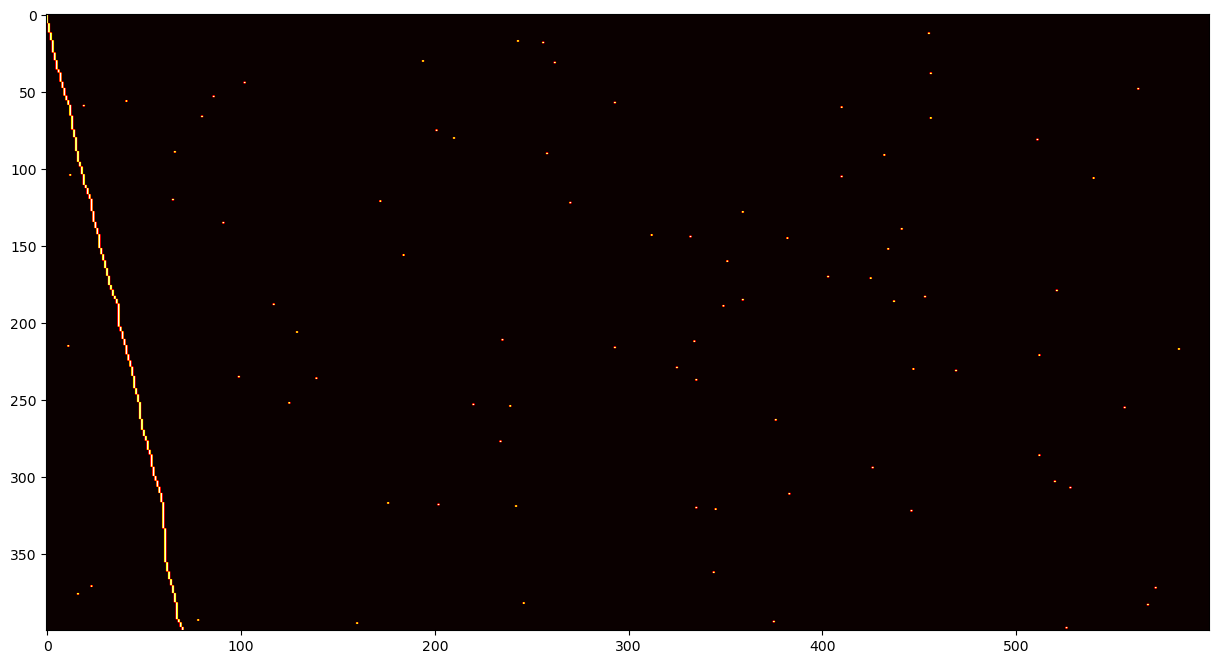

In [28]:
# see the edge features which are shape (n_edges, n_nodes + weight)
# notice that had we used filter_weighted_edges to create a new graphistry instance and then .build_gnn() we would get
# a different n_edges. Useful to keep in mind when building models without an explicit edge_dataframe
plt.figure(figsize=(15,8))
plt.imshow(G.edata['feature'][:400, :600], aspect='auto', cmap='hot')

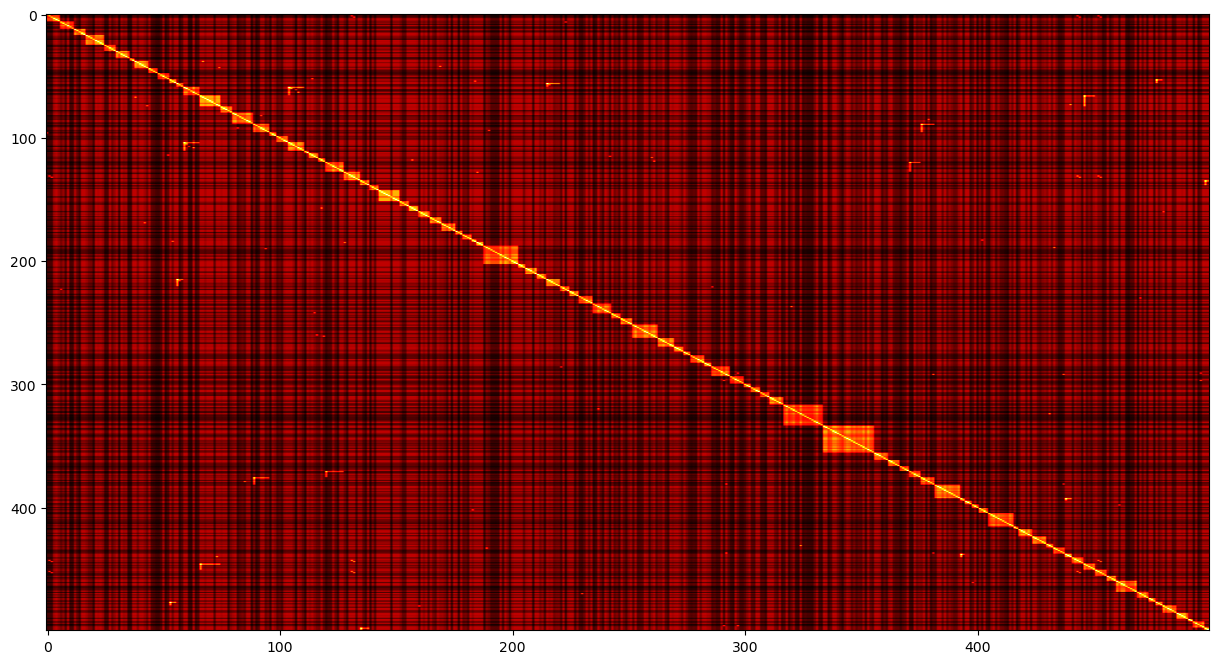

In [29]:
# see the way edges are related across the first 500 edges.
plt.figure(figsize=(15,8))
plt.imshow(np.cov(G.edata['feature'][:500]), aspect='auto', cmap='hot')

In [ ]:
# to see how to train a GNN, see the cyber or influence tutorial